### Imports ###

In [35]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'axes.labelsize': 20, 'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize': 16})
from scipy.interpolate import interp1d 

from model import jax_stream_model
N_PARTICLES  = 10100 # Denis wants more particles 
N_STEPS      = 100

from binned_model import *
from likelihood import *

### Define parameters for Test case ###

In [ ]:
logM, Rs, q = 1.25086380e+01,  1.00195364e+01,  7.76689838e-01
dirx, diry, dirz = -1.15103226e+00, 2.06019306e-01,  3.17610572e-01

logm, rs = 8.26199982e+00,  2.31002502e+00

x0, y0, z0 = 4.76810585e+01,  0.0, 1.42045508e+00
vx0, vy0, vz0 = 2.34644199e+02,  3.00594462e+02, -2.00273272e+02

time = 2.30310246e+00
alpha = 1.09464437e+00

In [ ]:
tail = 0 
min_count = 101
seed = np.random.randint(0, 2**32 - 1)
q_true = np.random.uniform(0.5, 1.5)
logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha = sample_params_data(q_true, seed)
theta_stream, x_stream, y_stream, vz_stream, count, r_meds, w_meds, x_meds, y_meds, vz_meds = jax_stream_model(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, 
                                                                                                        tail, min_count, seed)

plt.scatter(x_stream, y_stream, c=theta_stream, s=1, cmap='seismic', alpha=0.5, vmin=-2* np.pi, vmax=2*np.pi)
plt.colorbar(label='Angle (radians)')
plt.scatter(x_meds, y_meds, c='lime')
plt.axvline(0, color='grey', linestyle='--')
plt.axhline(0, color='grey', linestyle='--')
plt.axis('equal')

### (1) Generate normal stream using your JAX pipeline ###

In [ ]:
### Define this JAX model as the Data ###
seed = 111
tail = 0 
min_count = 101

theta_stream, x_stream, y_stream, vz_stream, count, r_meds, w_meds, x_meds, y_meds, vz_meds = jax_stream_model(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, 
                                                                                                        tail, min_count, seed)
bin_edges = jnp.linspace(-2 * jnp.pi, 2 * jnp.pi, N_BINS + 1)
theta_meds = 0.5 * (bin_edges[:-1] + bin_edges[1:]) * r_meds/r_meds

dict_data = {'theta_stream': theta_stream, 'x_stream': x_stream, 'y_stream': y_stream,
             'theta_meds': theta_meds, 'r_meds': r_meds, 'w_meds': w_meds, 'x_meds': x_meds, 'y_meds': y_meds, 'sig_meds': w_meds/np.sqrt(count)}

In [56]:
N = 100
all_chi2 = []
for s in tqdm(range(N), leave=True):
    _, _, _, _, _, r_meds, _, _, _, _ = jax_stream_model(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail, min_count, s)
    all_chi2.append(np.nanmean((r_meds - dict_data['r_meds'])**2/dict_data['sig_meds']**2))
mean_chi2_seed = np.mean(all_chi2)
std_chi2_seed = np.std(all_chi2)
print(f'Mean chi2 for {N} seeds: {mean_chi2_seed:.3f} +- {std_chi2_seed:.3f}')

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]

Mean chi2 for 100 seeds: 1.777 +- 0.599


(-158.53563423289214, 93.50173694962956, -94.33250815310099, 93.65710280247355)

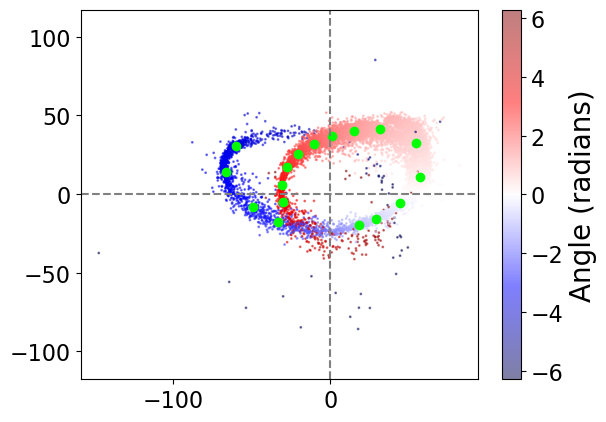

In [57]:
plt.scatter(dict_data['x_stream'], dict_data['y_stream'], c=dict_data['theta_stream'], s=1, cmap='seismic', alpha=0.5, vmin=-2* np.pi, vmax=2*np.pi)
plt.colorbar(label='Angle (radians)')
plt.scatter(dict_data['x_meds'], dict_data['y_meds'], c='lime')
plt.axvline(0, color='grey', linestyle='--')
plt.axhline(0, color='grey', linestyle='--')
plt.axis('equal')

### (2) Start with basic naive approach ###

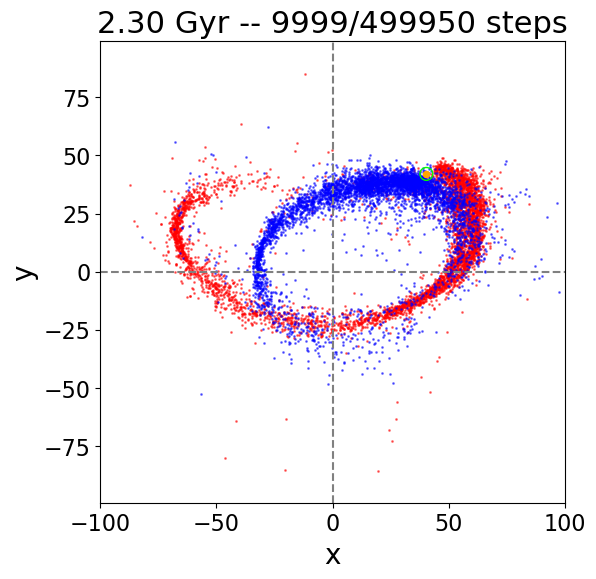

In [360]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 6))
sc_trailing = ax.scatter([], [], s=1, c='red', alpha=0.5)
sc_leading  = ax.scatter([], [], s=1, c='blue', alpha=0.5)
sat_sc = ax.scatter([], [], s=20, c='orange')

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stream Evolution')
ax.axis('equal')
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')

circle = plt.Circle((0, 0), 5, color='lime', fill=False, lw=1)  # Example circle around the satellite
ax.add_patch(circle)

def update(i):
    sc_trailing.set_offsets(np.column_stack((xv_stream[i, ::2, 0], xv_stream[i, ::2, 1])))
    sc_leading.set_offsets(np.column_stack((xv_stream[i, 1::2, 0], xv_stream[i, 1::2, 1])))
    sat_sc.set_offsets([[xv_sat_forward[i, 0], xv_sat_forward[i, 1]]])

    ax.set_title(f'{time_steps[i]:.2f} Gyr -- {list_n_steps[i]}/{np.sum(list_n_steps[:i+1])} steps')

    circle.set_center((xv_sat_forward[i, 0], xv_sat_forward[i, 1]))
    circle.set_radius(rj[i])  # Update the radius if needed

    return sc_trailing, sc_leading, sat_sc

ani = FuncAnimation(fig, update, frames=xv_stream.shape[0], interval=100, blit=True)
HTML(ani.to_jshtml())

ani.save('normal_stream_evolution.mp4', writer='ffmpeg', fps=10)

Above is just a normal Spray stream coded directly in Python. Now let's add a threshold radius, above which all particules are binned and considered to have a wait. We take twice the Jacobian radius and bin 

In [ ]:
dict_model_baseline = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail, r_thresh=np.inf, N_thresh=np.inf, percentiles=[])
chi2_baseline = condensed_likelihood(dict_data['theta_meds'], dict_data['r_meds'], dict_data['sig_meds'], dict_model_baseline['theta_bin'], dict_model_baseline['r_bin'])

100%|██████████| 99/99 [06:23<00:00,  3.87s/it]


In [61]:
np.nanmean(abs(dict_data['r_meds'] - dict_model_baseline['r_bin']))

1.1722755401071934

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


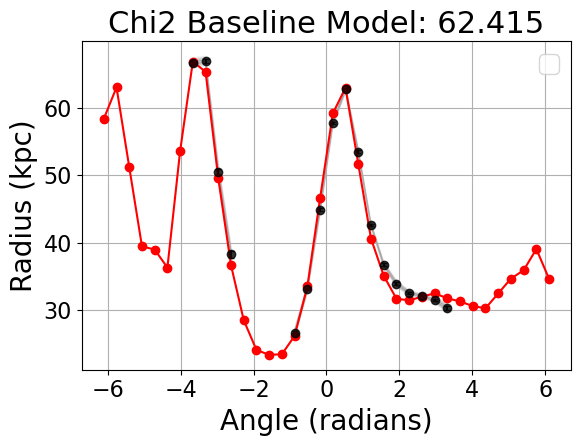

In [59]:
plt.title(f'Chi2 Baseline Model: {chi2_baseline:.3f}')
plt.xlabel('Angle (radians)')
plt.ylabel('Radius (kpc)')
plt.legend()
plt.grid()
plt.tight_layout()

plt.errorbar(dict_data['theta_meds'], dict_data['r_meds'], yerr=dict_data['sig_meds'], fmt='o', color='black', label='Normal', alpha=0.8, capsize=2)

plt.fill_between(dict_data['theta_meds'], dict_data['r_meds'] -   dict_data['sig_meds'], dict_data['r_meds'] +   dict_data['sig_meds'], color='gray', alpha=0.3)
plt.fill_between(dict_data['theta_meds'], dict_data['r_meds'] - 2*dict_data['sig_meds'], dict_data['r_meds'] + 2*dict_data['sig_meds'], color='gray', alpha=0.2)
plt.fill_between(dict_data['theta_meds'], dict_data['r_meds'] - 3*dict_data['sig_meds'], dict_data['r_meds'] + 3*dict_data['sig_meds'], color='gray', alpha=0.1)

plt.plot(dict_model_baseline['theta_bin'], dict_model_baseline['r_bin'], '-or', label='Baseline Model')


In [62]:
N_percentiles = [ 
    # [],
    # [50], 
    # [16, 84],
    # [25, 50, 75],
    [20, 40, 60, 80], 
    # [10, 20, 30, 40, 50, 60, 70, 80, 90],
    # [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], 
    # np.arange(1, 100, 1),
]

r_thresh = 2.0
N_thresh = 12

chi2 = []
N_bins = []
N_steps = []
for percentiles in N_percentiles:
    dict_model = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail, r_thresh, N_thresh, percentiles)

    chi2.append(condensed_likelihood(dict_data['theta_meds'], dict_data['r_meds'], dict_data['sig_meds'], dict_model['theta_bin'], dict_model['r_bin']))
    N_bins.append(len(percentiles) + 1)
    N_steps.append(np.cumsum(dict_model['n_steps'])[-1])


100%|██████████| 99/99 [00:55<00:00,  1.80it/s]
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:208: RuntimeWarning: invalid value encountered in divide
  r_bin = np.histogram(final_theta_stream, bins=bin_edges, weights=r_stream * weight[-1, :])[0] / hist
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:209: RuntimeWarning: invalid value encountered in divide
  x_bin = np.histogram(final_theta_stream, bins=bin_edges, weights=x_stream * weight[-1, :])[0] / hist
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:210: RuntimeWarning: invalid value encountered in divide
  y_bin = np.histogram(final_theta_stream, bins=bin_edges, weights=y_stream * weight[-1, :])[0] / hist


In [72]:
np.nanmean(dict_data['sig_meds'])

0.2185214495249441

In [70]:
np.nanmean(dict_data['r_meds'] - dict_model['r_bin'])

0.4164072315093269

In [69]:
np.nanmean(dict_data['w_meds'])

4.30532139209479

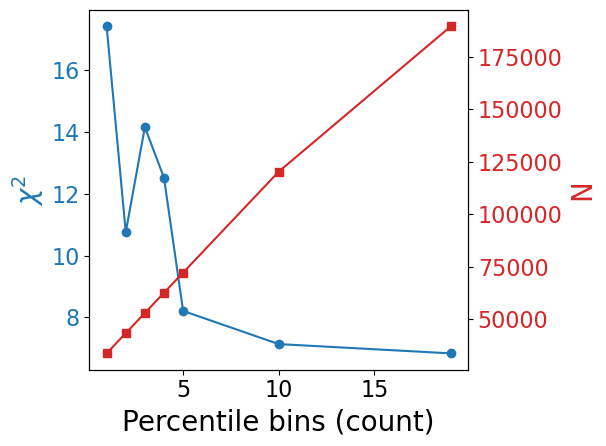

In [615]:
fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel('Percentile bins (count)')
ax1.set_ylabel(r'$\chi^2$', color=color1)
ax1.plot(N_bins, 
         chi2, 
         color=color1, marker='o', label='Likelihood')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('N', color=color2)
ax2.plot(N_bins, 
         N_steps, 
         color=color2, marker='s', label='N')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
# plt.savefig('logxhi2_percentile.pdf')
plt.show()

In [621]:
_, _, _, _, r_meds, _, _, _, _ = jax_stream_model(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, min_count=11, seed=222)

In [626]:
np.nanmean((dict_normal['r'] - r_meds)**2/ sig_combined**2)

18.164677095511408

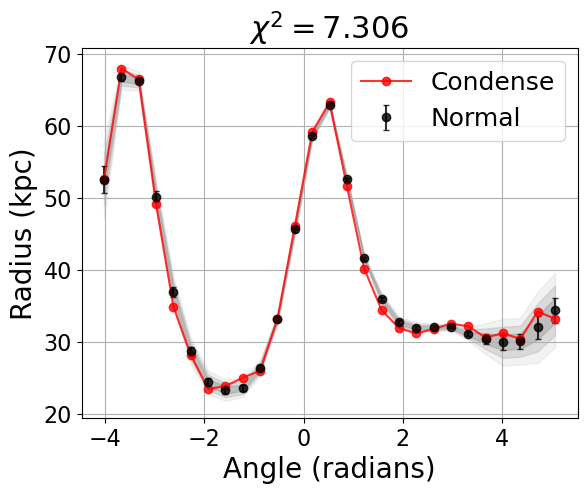

In [620]:
# plt.plot(dict_normal['theta'], dict_normal['r'], '-ko', label='Normal', alpha=0.5)
sig_data = 0 #1/100 * dict_normal['r']
sig_combined = (dict_normal['r_sig']**2 + seed_r_std**2 + sig_data**2)**0.5
mean_combined = (dict_normal['r'] + seed_r_mean) / 2

plt.errorbar(dict_normal['theta'], mean_combined, yerr=sig_combined, fmt='o', color='black', label='Normal', alpha=0.8, capsize=2)

plt.fill_between(dict_normal['theta'], mean_combined - sig_combined, mean_combined + sig_combined, color='gray', alpha=0.3)
plt.fill_between(dict_normal['theta'], mean_combined - 2*sig_combined, mean_combined + 2*sig_combined, color='gray', alpha=0.2)
plt.fill_between(dict_normal['theta'], mean_combined - 3*sig_combined, mean_combined + 3*sig_combined, color='gray', alpha=0.1)

dict_percentile = {'theta': dict_model['theta_bin'], 'r': dict_model['r_bin'], 'x': x_bin, 'y': y_bin}
mask = ~np.isnan(dict_percentile['r'])
theta_bin_clean = dict_percentile['theta'][mask]
r_bin_clean = dict_percentile['r'][mask]
interp_r = interp1d(theta_bin_clean, r_bin_clean, kind='linear', bounds_error=False, fill_value='extrapolate')
dict_percentile_r = interp_r(dict_normal['theta'])
plt.plot(dict_percentile['theta'][~np.isnan(mean_combined)], dict_percentile_r[~np.isnan(mean_combined)], '-ro', label='Condense', alpha=0.8)

plt.title(r'$\chi^2 = {:.3f}$'.format(
    np.nanmean((dict_percentile_r - mean_combined)**2 / sig_combined**2)
), color='black')
plt.xlabel('Angle (radians)')
plt.ylabel('Radius (kpc)')
plt.legend()
plt.grid()

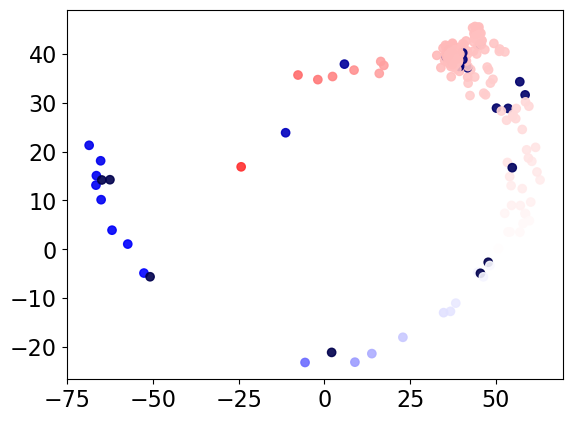

In [550]:
plt.scatter(dict_model['x_stream'], dict_model['y_stream'], c=dict_model['theta_stream'], cmap='seismic', alpha=0.9, vmin=-2 * np.pi, vmax=2 * np.pi)

In [542]:
dict_model.keys()

dict_keys(['theta_stream', 'r_stream', 'x_stream', 'y_stream', 'weight', 'theta_bin', 'r_bin', 'x_bin', 'y_bin', 'r_thresh', 'N_thresh', 'n_steps'])

In [543]:
dict_model['theta_stream'].shape

(10100,)

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 6))
stream_sc = ax.scatter([], [], s=1, c='blue', alpha=0.5)
sat_sc = ax.scatter([], [], s=20, c='red')

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stream Evolution')
ax.axis('equal')
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')

circle_rj = plt.Circle((0, 0), 5, color='lime', fill=False, lw=1)  # Example circle around the satellite
ax.add_patch(circle_rj)

circle_r_min = plt.Circle((0, 0), 5, color='purple', fill=False, lw=1)  # Example circle around the satellite
ax.add_patch(circle_r_min)

def update(i):
    stream_sc.set_offsets(np.column_stack((dict_model, xv_stream[i, ::2, 1])))
    stream_sc.set_sizes(weight[i, ::2] * 2)  # Scale sizes by weight
    sat_sc.set_offsets([[xv_sat_forward[i, 0], xv_sat_forward[i, 1]]])

    ax.set_title(f'{time_steps[i]:.2f} Gyr -- {list_n_steps[i]}/{np.sum(list_n_steps[:i+1])} steps')

    circle_rj.set_center((xv_sat_forward[i, 0], xv_sat_forward[i, 1]))
    circle_rj.set_radius(rj[i])  # Update the radius if needed

    circle_r_min.set_center((xv_sat_forward[i, 0], xv_sat_forward[i, 1]))
    circle_r_min.set_radius(5 * rj[i])  # Update the radius to

    return sc_trailing, sc_leading, sat_sc

ani = FuncAnimation(fig, update, frames=xv_stream.shape[0], interval=100, blit=True)
HTML(ani.to_jshtml())

ani.save('binng_stream_evolution.mp4', writer='ffmpeg', fps=10)

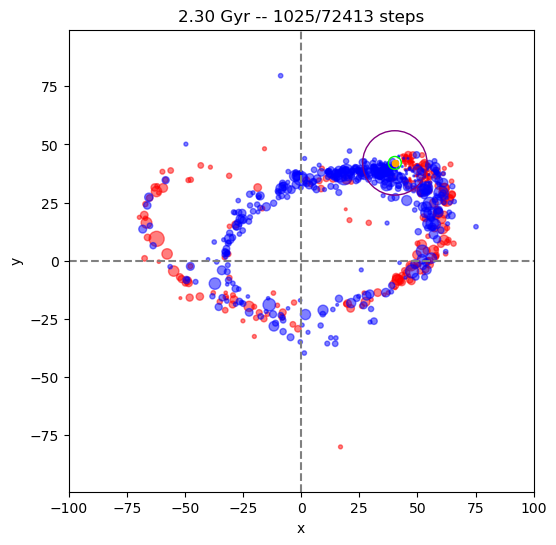

In [170]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6, 6))
sc_trailing = ax.scatter([], [], s=1, c='red', alpha=0.5)
sc_leading  = ax.scatter([], [], s=1, c='blue', alpha=0.5)
sat_sc = ax.scatter([], [], s=20, c='orange')

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Stream Evolution')
ax.axis('equal')
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')

circle_rj = plt.Circle((0, 0), 5, color='lime', fill=False, lw=1)  # Example circle around the satellite
ax.add_patch(circle_rj)

circle_r_min = plt.Circle((0, 0), 5, color='purple', fill=False, lw=1)  # Example circle around the satellite
ax.add_patch(circle_r_min)

def update(i):
    sc_trailing.set_offsets(np.column_stack((xv_stream[i, ::2, 0], xv_stream[i, ::2, 1])))
    sc_trailing.set_sizes(weight[i, ::2] * 2)  # Scale sizes by weight
    sc_leading.set_offsets(np.column_stack((xv_stream[i, 1::2, 0], xv_stream[i, 1::2, 1])))
    sc_leading.set_sizes(weight[i, 1::2] * 2)  # Scale sizes by weight
    sat_sc.set_offsets([[xv_sat_forward[i, 0], xv_sat_forward[i, 1]]])

    ax.set_title(f'{time_steps[i]:.2f} Gyr -- {list_n_steps[i]}/{np.sum(list_n_steps[:i+1])} steps')

    circle_rj.set_center((xv_sat_forward[i, 0], xv_sat_forward[i, 1]))
    circle_rj.set_radius(rj[i])  # Update the radius if needed

    circle_r_min.set_center((xv_sat_forward[i, 0], xv_sat_forward[i, 1]))
    circle_r_min.set_radius(5 * rj[i])  # Update the radius to

    return sc_trailing, sc_leading, sat_sc

ani = FuncAnimation(fig, update, frames=xv_stream.shape[0], interval=100, blit=True)
HTML(ani.to_jshtml())

ani.save('binng_stream_evolution.mp4', writer='ffmpeg', fps=10)

Doing some diagnostic plots

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(2, 3, figsize=(14, 10))#, constrained_layout=True)

plt.rcParams.update({'font.size': 18, 'axes.labelsize': 20, 'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

# Compute absolute min/max for each dimension across all non-empty trailing and leading particles
mins = [np.inf]*6
maxs = [-np.inf]*6
ymaxs = [0]*6
for plist in particules_trailing + particules_leading:
    if len(plist) > 0:
        for k in range(6):
            mins[k] = min(mins[k], np.nanmin(plist[:, k]))
            maxs[k] = max(maxs[k], np.nanmax(plist[:, k]))
# Precompute fixed bins for each dimension
bins = [np.linspace(mins[k], maxs[k], 51) for k in range(6)]
for idx in range(6):
    all_vals = np.concatenate([plist[:, idx] for plist in particules_trailing + particules_leading if len(plist) > 0])
    counts, _ = np.histogram(all_vals, bins=bins[idx])
    ymaxs[idx] = counts.max()

labels = [
    ('x (kpc)', 0, 0), ('y (kpc)', 0, 1), ('z (kpc)', 0, 2),
    ('vx (km/s)', 1, 0), ('vy (km/s)', 1, 1), ('vz (km/s)', 1, 2)
]

def update_hist(i):
    for idx, (label, row, col) in enumerate(labels):
        ax = axes[row, col]
        ax.clear()
        ax.set_xlabel(label)
        ax.set_xlim(mins[idx], maxs[idx])
        ax.set_yscale('log')
        ax.set_ylim(1, ymaxs[idx])
        ax.tick_params(axis='both', which='major', labelsize=16)
        if len(particules_trailing[i]) > 0:
            ax.hist(particules_trailing[i][:, idx] - xv_sat_forward[i+1, idx], bins=bins[idx], histtype='bar', color='red', edgecolor='black', alpha=0.7, label='Trailing')
        if len(particules_leading[i]) > 0:
            ax.hist(particules_leading[i][:, idx] - xv_sat_forward[i+1, idx], bins=bins[idx], histtype='bar', color='blue', edgecolor='black', alpha=0.5, label='Leading')
    fig.suptitle(f"6D distributions at binning (Step {time_steps[i]:.2f} Gyr)", fontsize=24)#, y=1.05)
    return axes.flat

ani = FuncAnimation(fig, update_hist, frames=len(particules_trailing), interval=300, blit=False)
HTML(ani.to_jshtml())

ani.save('6D_distribution_before_binning.mp4', writer='ffmpeg', fps=10)

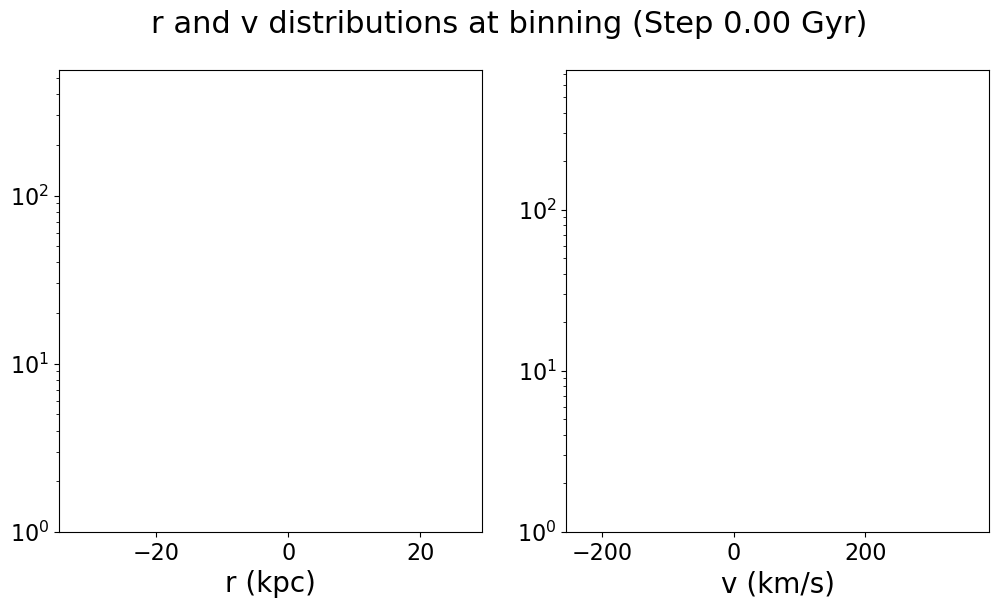

In [348]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, axes = plt.subplots(1, 2, figsize=(12, 6))#, constrained_layout=True)

plt.rcParams.update({'font.size': 18, 'axes.labelsize': 20, 'axes.titlesize': 22, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

# Compute |r - r_sat| and |v| for all non-empty trailing and leading particles
r_trailing = [
    np.linalg.norm(plist[:, :3], axis=1) - np.linalg.norm(xv_sat_forward[i, :3])
    for i, plist in enumerate(particules_trailing) if len(plist) > 0
]
v_trailing = [
    np.linalg.norm(plist[:, 3:], axis=1) - np.linalg.norm(xv_sat_forward[i, 3:])
    for i, plist in enumerate(particules_trailing) if len(plist) > 0
]
r_leading = [
    np.linalg.norm(plist[:, :3], axis=1) - np.linalg.norm(xv_sat_forward[i, :3])
    for i, plist in enumerate(particules_leading) if len(plist) > 0
]
v_leading = [
    np.linalg.norm(plist[:, 3:], axis=1) - np.linalg.norm(xv_sat_forward[i, 3:])
    for i, plist in enumerate(particules_leading) if len(plist) > 0
]

# Find global min/max for bins
all_r = np.concatenate(r_trailing + r_leading)
all_v = np.concatenate(v_trailing + v_leading)
r_bins = np.linspace(np.nanmin(all_r), np.nanmax(all_r), 51)
v_bins = np.linspace(np.nanmin(all_v), np.nanmax(all_v), 51)
r_ymax = np.histogram(all_r, bins=r_bins)[0].max()
v_ymax = np.histogram(all_v, bins=v_bins)[0].max()

def update_hist(i):
    ax_r, ax_v = axes
    ax_r.clear()
    ax_v.clear()
    ax_r.set_xlabel('r (kpc)')
    ax_v.set_xlabel('v (km/s)')
    ax_r.set_yscale('log')
    ax_v.set_yscale('log')
    ax_r.set_xlim(r_bins[0], r_bins[-1])
    ax_v.set_xlim(v_bins[0], v_bins[-1])
    ax_r.set_ylim(1, r_ymax)
    ax_v.set_ylim(1, v_ymax)
    if len(particules_trailing[i]) > 0:
        r_trail = np.linalg.norm(particules_trailing[i][:, :3], axis=1) - np.linalg.norm(xv_sat_forward[i, :3]) #r_trailing[i] #np.linalg.norm(particules_trailing[i][:, :3], axis=1)
        v_trail = np.linalg.norm(particules_trailing[i][:, 3:], axis=1) - np.linalg.norm(xv_sat_forward[i, 3:]) #v_trailing[i] #np.linalg.norm(particules_trailing[i][:, 3:], axis=1)
        ax_r.hist(r_trail, bins=r_bins, color='red', edgecolor='black', alpha=0.7, label='Trailing')
        ax_v.hist(v_trail, bins=v_bins, color='red', edgecolor='black', alpha=0.7, label='Trailing')
    if len(particules_leading[i]) > 0:
        r_lead = np.linalg.norm(particules_leading[i][:, :3], axis=1) - np.linalg.norm(xv_sat_forward[i, :3]) #r_trailing[i] #np.linalg.norm(particules_trailing[i][:, :3], axis=1)
        v_lead = np.linalg.norm(particules_leading[i][:, 3:], axis=1) - np.linalg.norm(xv_sat_forward[i, 3:]) #v_trailing[i] #np.linalg.norm(particules_trailing[i][:, 3:], axis=1)
        ax_r.hist(r_lead, bins=r_bins, color='blue', edgecolor='black', alpha=0.5, label='Leading')
        ax_v.hist(v_lead, bins=v_bins, color='blue', edgecolor='black', alpha=0.5, label='Leading')
    fig.suptitle(f"r and v distributions at binning (Step {time_steps[i]:.2f} Gyr)", fontsize=22)#, y=1.05)
    return axes.flat

ani = FuncAnimation(fig, update_hist, frames=len(particules_trailing), interval=300, blit=False)
HTML(ani.to_jshtml())

ani.save('r&v_distribution_before_binning.mp4', writer='ffmpeg', fps=10)


### Making plots for Time and Likelihood as a function of R threshold and ###

In [210]:
%reload_ext autoreload
%autoreload 2

from binned_model import *

In [221]:
dict_rt0_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=0, N_thresh=12, percentile=True)
dict_rt1_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=1, N_thresh=12, percentile=True)
dict_rt2_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=2, N_thresh=12, percentile=True)
dict_rt3_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=3, N_thresh=12, percentile=True)
dict_rt4_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=4, N_thresh=12, percentile=True)
dict_rt5_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=5, N_thresh=12, percentile=True)
dict_rt6_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=6, N_thresh=12, percentile=True)
dict_rt7_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=7, N_thresh=12, percentile=True)
dict_rt8_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=8, N_thresh=12, percentile=True)
dict_rt9_Nt5  = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=9, N_thresh=12, percentile=True)
dict_rt10_Nt5 = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=10, N_thresh=12, percentile=True)
dict_rt15_Nt5 = condensed_track(logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha, tail=0, r_thresh=15, N_thresh=12, percentile=True)

100%|██████████| 99/99 [00:30<00:00,  3.20it/s]
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:208: RuntimeWarning: invalid value encountered in divide
  # Compute weighted averages for r_stream, x_stream, y_stream using the same bins
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:209: RuntimeWarning: invalid value encountered in divide
  r_bin = np.histogram(final_theta_stream, bins=bin_edges, weights=r_stream * weight[-1, :])[0] / hist
/Users/davidchemaly/Documents/Cambridge/PhD_Projects/Stream_BinModeling/binned_model.py:210: RuntimeWarning: invalid value encountered in divide
  x_bin = np.histogram(final_theta_stream, bins=bin_edges, weights=x_stream * weight[-1, :])[0] / hist
100%|██████████| 99/99 [04:03<00:00,  2.46s/it]


In [217]:
from scipy.interpolate import interp1d
def Xhi2(dict_data, dict_model):
    # Remove NaNs for interpolation
    mask = ~np.isnan(dict_model['r_bin'])
    theta_bin_clean = dict_model['theta_bin'][mask]
    r_bin_clean = dict_model['r_bin'][mask]

    interp_r = interp1d(theta_bin_clean, r_bin_clean, kind='linear', bounds_error=False, fill_value='extrapolate')

    return np.nanmean((interp_r(dict_data['theta']) - mean_combined)**2/ sig_combined**2)

In [222]:
like_rt0_Nt5 = Xhi2(dict_normal, dict_rt0_Nt5)
N_rt0_Nt5 = np.cumsum(dict_rt0_Nt5['n_steps'])[-1]

like_rt1_Nt5 = Xhi2(dict_normal, dict_rt1_Nt5)
N_rt1_Nt5 = np.cumsum(dict_rt1_Nt5['n_steps'])[-1]

like_rt2_Nt5 = Xhi2(dict_normal, dict_rt2_Nt5)
N_rt2_Nt5 = np.cumsum(dict_rt2_Nt5['n_steps'])[-1]

like_rt3_Nt5 = Xhi2(dict_normal, dict_rt3_Nt5)
N_rt3_Nt5 = np.cumsum(dict_rt3_Nt5['n_steps'])[-1]

like_rt4_Nt5 = Xhi2(dict_normal, dict_rt4_Nt5)
N_rt4_Nt5 = np.cumsum(dict_rt4_Nt5['n_steps'])[-1]

like_rt5_Nt5 = Xhi2(dict_normal, dict_rt5_Nt5)
N_rt5_Nt5 = np.cumsum(dict_rt5_Nt5['n_steps'])[-1]

like_rt6_Nt5 = Xhi2(dict_normal, dict_rt6_Nt5)
N_rt6_Nt5 = np.cumsum(dict_rt6_Nt5['n_steps'])[-1]

like_rt7_Nt5 = Xhi2(dict_normal, dict_rt7_Nt5)
N_rt7_Nt5 = np.cumsum(dict_rt7_Nt5['n_steps'])[-1]

like_rt8_Nt5 = Xhi2(dict_normal, dict_rt8_Nt5)
N_rt8_Nt5 = np.cumsum(dict_rt8_Nt5['n_steps'])[-1]

like_rt9_Nt5 = Xhi2(dict_normal, dict_rt9_Nt5)
N_rt9_Nt5 = np.cumsum(dict_rt9_Nt5['n_steps'])[-1]

like_rt10_Nt5 = Xhi2(dict_normal, dict_rt10_Nt5)
N_rt10_Nt5 = np.cumsum(dict_rt10_Nt5['n_steps'])[-1]

like_rt15_Nt5 = Xhi2(dict_normal, dict_rt15_Nt5)
N_rt15_Nt5 = np.cumsum(dict_rt15_Nt5['n_steps'])[-1]

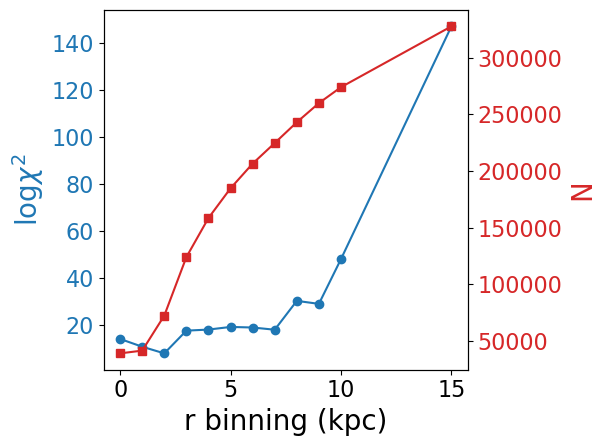

In [224]:
fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel('r binning (kpc)')
ax1.set_ylabel(r'log$\chi^2$', color=color1)
ax1.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15], 
         [like_rt0_Nt5, like_rt1_Nt5, like_rt2_Nt5, like_rt3_Nt5, like_rt4_Nt5, like_rt5_Nt5, like_rt6_Nt5, like_rt7_Nt5, like_rt8_Nt5, like_rt9_Nt5, like_rt10_Nt5, like_rt15_Nt5], 
         color=color1, marker='o', label='Likelihood')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('N', color=color2)
ax2.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15], 
         [N_rt0_Nt5, N_rt1_Nt5, N_rt2_Nt5, N_rt3_Nt5, N_rt4_Nt5, N_rt5_Nt5, N_rt6_Nt5, N_rt7_Nt5, N_rt8_Nt5, N_rt9_Nt5, N_rt10_Nt5, N_rt15_Nt5], 
         color=color2, marker='s', label='N')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
# plt.savefig('logxhi2_percentile.pdf')
plt.show()

### (4) Write everything in JAX ###